# V10 Phase 1: Causal Factor Crowding - Real Data Test

**Goal**: Test if causal/lead-lag relationships exist between factor crowding levels using real Fama-French data

**Previous**: Validated methodology on synthetic data (MOM → SMB at lag 3 detected ✅)

**Data**: Fama-French 5 Factors + Momentum (Daily, 1990-2024)

In [1]:
# Install dependencies
!pip install pandas-datareader statsmodels -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded")

Libraries loaded


## 1. Load Fama-French Factor Data

In [3]:
import pandas_datareader.data as web

# Download Fama-French 5 Factors (Daily)
print("Downloading Fama-French 5 Factors...")
ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start='1990-01-01')[0]

# Download Momentum Factor (Daily)
print("Downloading Momentum Factor...")
mom = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start='1990-01-01')[0]

# Combine
factors = ff5.join(mom, how='inner')
factors.columns = ['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'MOM']

# Remove risk-free rate
factors['MKT'] = factors['MKT'] - factors['RF']
factors = factors.drop('RF', axis=1)

print(f"\nLoaded {len(factors)} days of factor data")
print(f"Factors: {list(factors.columns)}")
print(f"Date range: {factors.index[0]} to {factors.index[-1]}")
factors.head()


Loaded 9026 days of factor data
Factors: ['MKT', 'SMB', 'HML', 'RMW', 'CMA', 'MOM']
Date range: 1990-01-02 00:00:00 to 2025-10-31 00:00:00


,MKT,SMB,HML,RMW,CMA,MOM
Date,,,,,,
1990-01-02,1.41,-0.68,-0.06,0.19,-0.44,-1.08
1990-01-03,-0.09,0.71,-0.26,0.16,-0.45,-0.31
1990-01-04,-0.74,0.44,-0.24,-0.05,-0.04,-0.34
1990-01-05,-0.88,0.73,-0.21,0.01,-0.12,-0.34
1990-01-08,0.27,-0.40,-0.27,0.04,0.30,0.19


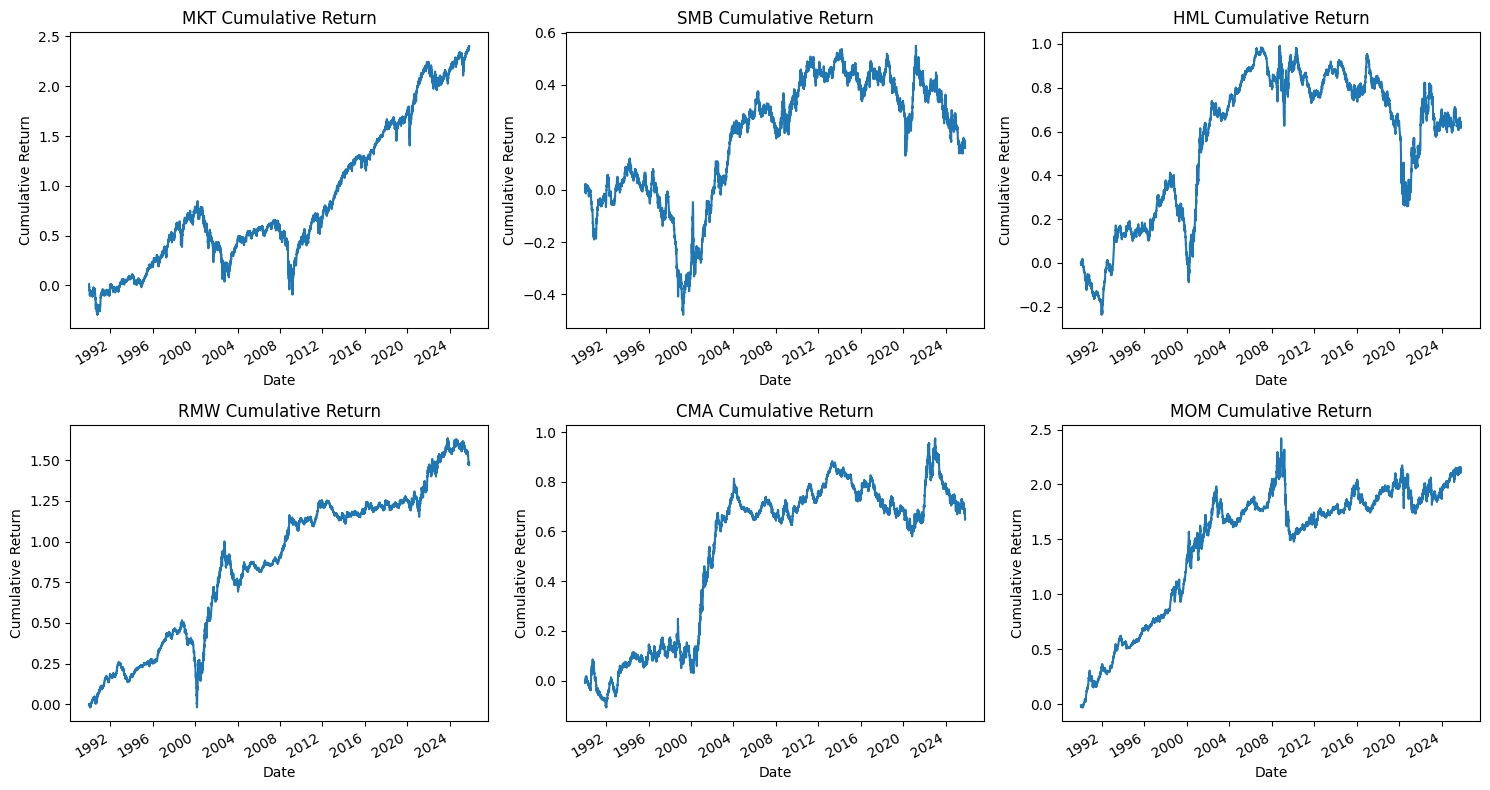

In [4]:
# Quick visualization of factor returns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(factors.columns):
    (factors[col] / 100).cumsum().plot(ax=axes[i], title=f'{col} Cumulative Return')
    axes[i].set_ylabel('Cumulative Return')

plt.tight_layout()
plt.show()

## 2. Compute Crowding Proxy

Simple proxy: Rolling volatility (z-scored)
- Higher volatility = potential crowding unwinding

In [5]:
def compute_crowding_proxy(factor_returns, window=60):
    """
    Simple crowding proxy: z-scored rolling volatility
    Higher volatility = potential crowding unwinding risk
    """
    crowding = pd.DataFrame(index=factor_returns.index)
    
    for col in factor_returns.columns:
        vol = factor_returns[col].rolling(window).std()
        # Z-score (rolling 252-day mean/std)
        mean = vol.rolling(252).mean()
        std = vol.rolling(252).std()
        crowding[col] = (vol - mean) / std
    
    return crowding.dropna()

# Compute crowding
crowding = compute_crowding_proxy(factors, window=60)
print(f"Crowding data: {crowding.shape[0]} days, {crowding.shape[1]} factors")
print(f"Date range: {crowding.index[0]} to {crowding.index[-1]}")

Crowding data: 8716 days, 6 factors
Date range: 1991-03-25 00:00:00 to 2025-10-31 00:00:00


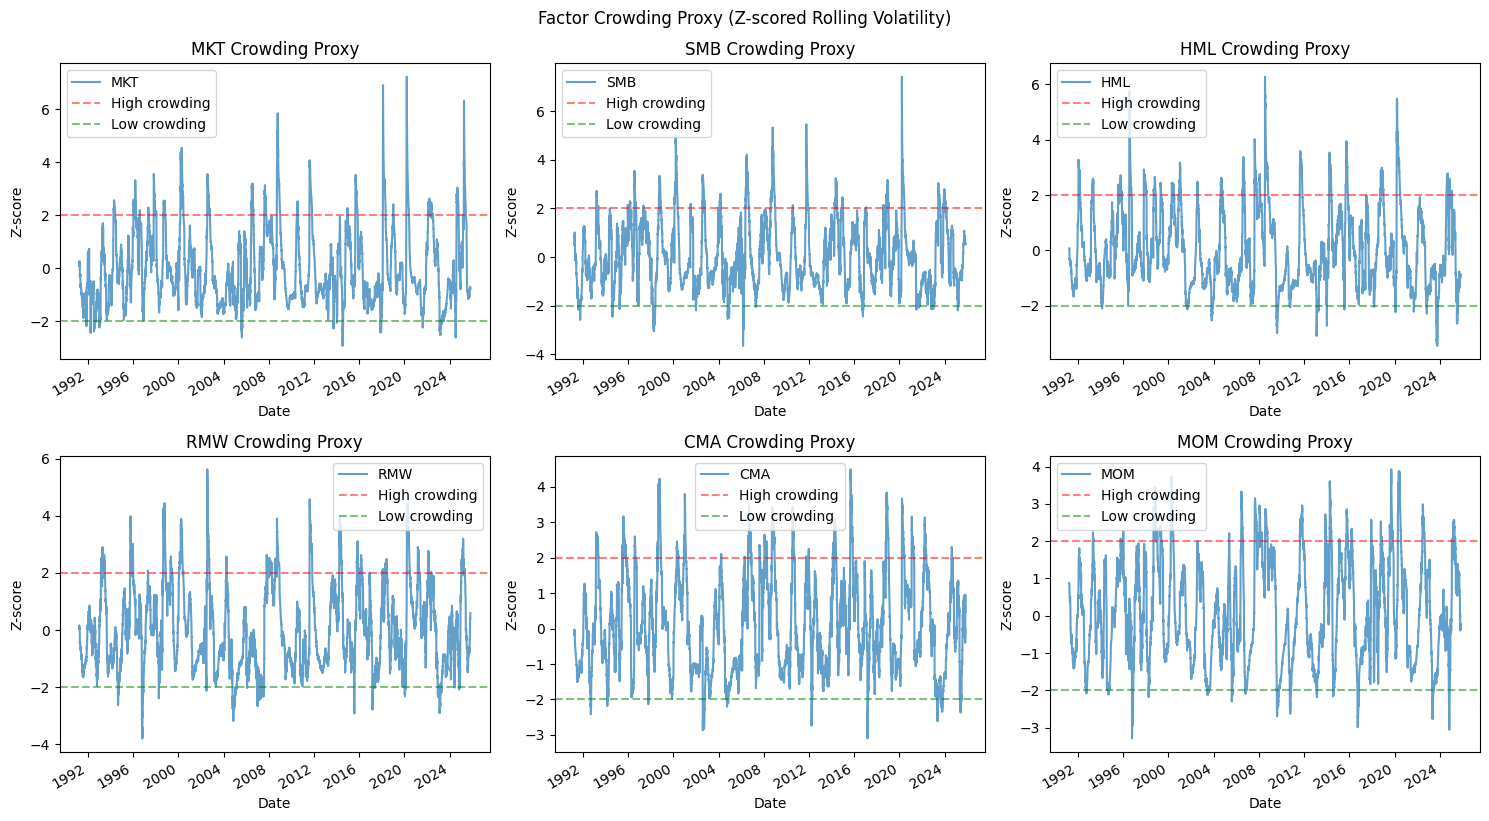

In [6]:
# Visualize crowding proxy
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(crowding.columns):
    crowding[col].plot(ax=axes[i], title=f'{col} Crowding Proxy', alpha=0.7)
    axes[i].axhline(y=2, color='r', linestyle='--', alpha=0.5, label='High crowding')
    axes[i].axhline(y=-2, color='g', linestyle='--', alpha=0.5, label='Low crowding')
    axes[i].set_ylabel('Z-score')
    axes[i].legend()

plt.tight_layout()
plt.suptitle('Factor Crowding Proxy (Z-scored Rolling Volatility)', y=1.02)
plt.show()

## 3. Test 1: Cross-Correlation Analysis

Find lead-lag relationships between factor crowding levels

In [7]:
def analyze_cross_correlation(crowding, max_lag=30):
    """
    Find lead-lag relationships via cross-correlation
    Peak at positive lag = first variable leads second
    """
    factors_list = crowding.columns.tolist()
    results = []
    
    for i, f1 in enumerate(factors_list):
        for j, f2 in enumerate(factors_list):
            if i >= j:
                continue
            
            # Cross-correlation at different lags
            x = crowding[f1].values
            y = crowding[f2].values
            
            correlations = []
            lags = range(-max_lag, max_lag + 1)
            
            for lag in lags:
                if lag < 0:
                    c = np.corrcoef(x[-lag:], y[:lag])[0, 1]
                elif lag > 0:
                    c = np.corrcoef(x[:-lag], y[lag:])[0, 1]
                else:
                    c = np.corrcoef(x, y)[0, 1]
                correlations.append(c if not np.isnan(c) else 0)
            
            # Find peak
            peak_idx = np.argmax(np.abs(correlations))
            peak_lag = list(lags)[peak_idx]
            peak_corr = correlations[peak_idx]
            
            results.append({
                'factor1': f1,
                'factor2': f2,
                'peak_lag': peak_lag,
                'peak_corr': peak_corr,
                'correlations': correlations,
                'lags': list(lags)
            })
    
    return pd.DataFrame(results)

xcorr_results = analyze_cross_correlation(crowding, max_lag=30)
print("Cross-Correlation Results:")
print("=" * 60)

Cross-Correlation Results:


In [8]:
# Show significant lead-lag relationships
significant = xcorr_results[
    (xcorr_results['peak_corr'].abs() > 0.15) & 
    (xcorr_results['peak_lag'].abs() > 2)
].copy()

if len(significant) > 0:
    print("\nSignificant Lead-Lag Relationships:")
    print("-" * 60)
    for _, row in significant.iterrows():
        if row['peak_lag'] > 0:
            print(f"  {row['factor1']} → {row['factor2']}: lag={row['peak_lag']} days, corr={row['peak_corr']:.3f}")
        else:
            print(f"  {row['factor2']} → {row['factor1']}: lag={-row['peak_lag']} days, corr={row['peak_corr']:.3f}")
else:
    print("\nNo significant lead-lag relationships found (threshold: |corr|>0.15, |lag|>2)")

# Show all pairs
print("\nAll Pair Results:")
print(xcorr_results[['factor1', 'factor2', 'peak_lag', 'peak_corr']].to_string())


No significant lead-lag relationships found (threshold: |corr|>0.15, |lag|>2)

All Pair Results:
   factor1 factor2  peak_lag  peak_corr
0      MKT     SMB         1   0.479317
1      MKT     HML         1   0.567589
2      MKT     RMW         0   0.565043
3      MKT     CMA         1   0.475114
4      MKT     MOM         1   0.570242
5      SMB     HML         0   0.493480
6      SMB     RMW         0   0.548446
7      SMB     CMA         1   0.430074
8      SMB     MOM         0   0.479550
9      HML     RMW         0   0.577648
10     HML     CMA         0   0.648842
11     HML     MOM         1   0.597471
12     RMW     CMA         0   0.544697
13     RMW     MOM         2   0.608869
14     CMA     MOM         0   0.483180


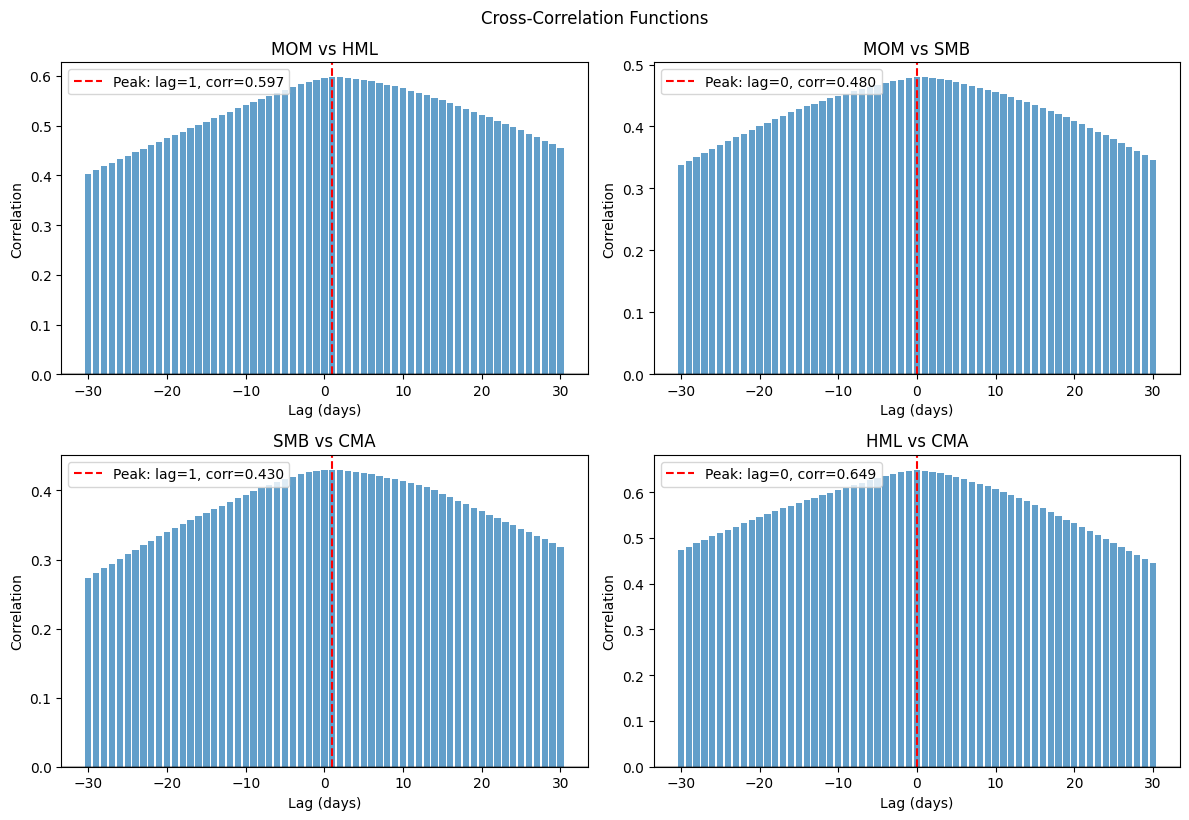

In [9]:
# Plot cross-correlation functions for key pairs
key_pairs = [('MOM', 'HML'), ('MOM', 'SMB'), ('SMB', 'CMA'), ('HML', 'CMA')]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for idx, (f1, f2) in enumerate(key_pairs):
    row = xcorr_results[(xcorr_results['factor1'] == f1) & (xcorr_results['factor2'] == f2)]
    if len(row) == 0:
        row = xcorr_results[(xcorr_results['factor1'] == f2) & (xcorr_results['factor2'] == f1)]
    
    if len(row) > 0:
        row = row.iloc[0]
        axes[idx].bar(row['lags'], row['correlations'], alpha=0.7)
        axes[idx].axvline(x=row['peak_lag'], color='r', linestyle='--', 
                         label=f'Peak: lag={row["peak_lag"]}, corr={row["peak_corr"]:.3f}')
        axes[idx].axhline(y=0, color='k', linestyle='-', alpha=0.3)
        axes[idx].set_title(f'{f1} vs {f2}')
        axes[idx].set_xlabel('Lag (days)')
        axes[idx].set_ylabel('Correlation')
        axes[idx].legend()

plt.tight_layout()
plt.suptitle('Cross-Correlation Functions', y=1.02)
plt.show()

## 4. Test 2: Granger Causality

In [10]:
from statsmodels.tsa.stattools import grangercausalitytests

def test_granger_causality(crowding, maxlag=20):
    """
    Test if one factor's crowding Granger-causes another's
    """
    factors_list = crowding.columns.tolist()
    n = len(factors_list)
    
    p_values = pd.DataFrame(np.nan, index=factors_list, columns=factors_list)
    best_lags = pd.DataFrame(np.nan, index=factors_list, columns=factors_list)
    
    print("Granger Causality Test Results:")
    print("=" * 60)
    print("(H0: X does NOT Granger-cause Y)")
    print()
    
    for cause in factors_list:
        for effect in factors_list:
            if cause == effect:
                continue
            
            # Granger test requires [effect, cause] order
            data = crowding[[effect, cause]].dropna()
            
            if len(data) < maxlag + 10:
                continue
            
            try:
                result = grangercausalitytests(data, maxlag=maxlag, verbose=False)
                
                # Find minimum p-value across all lags
                min_p = 1.0
                best_lag = 0
                for lag in range(1, maxlag + 1):
                    p = result[lag][0]['ssr_ftest'][1]
                    if p < min_p:
                        min_p = p
                        best_lag = lag
                
                p_values.loc[cause, effect] = min_p
                best_lags.loc[cause, effect] = best_lag
                
                if min_p < 0.05:
                    print(f"  * {cause} → {effect}: p={min_p:.4f} at lag={best_lag} days")
            except:
                pass
    
    return p_values, best_lags

granger_pvalues, granger_lags = test_granger_causality(crowding, maxlag=20)

Granger Causality Test Results:
(H0: X does NOT Granger-cause Y)

  * MKT → SMB: p=0.0000 at lag=9 days
  * MKT → HML: p=0.0000 at lag=9 days
  * MKT → RMW: p=0.0000 at lag=5 days
  * MKT → CMA: p=0.0000 at lag=7 days
  * MKT → MOM: p=0.0000 at lag=16 days
  * SMB → MKT: p=0.0004 at lag=18 days
  * SMB → HML: p=0.0000 at lag=4 days
  * SMB → RMW: p=0.0000 at lag=2 days
  * SMB → CMA: p=0.0000 at lag=19 days
  * SMB → MOM: p=0.0000 at lag=2 days
  * HML → MKT: p=0.0000 at lag=14 days
  * HML → SMB: p=0.0000 at lag=9 days
  * HML → RMW: p=0.0000 at lag=12 days
  * HML → CMA: p=0.0000 at lag=15 days
  * HML → MOM: p=0.0000 at lag=2 days
  * RMW → MKT: p=0.0000 at lag=3 days
  * RMW → SMB: p=0.0000 at lag=14 days
  * RMW → HML: p=0.0000 at lag=8 days
  * RMW → CMA: p=0.0000 at lag=5 days
  * RMW → MOM: p=0.0000 at lag=12 days
  * CMA → MKT: p=0.0001 at lag=2 days
  * CMA → SMB: p=0.0000 at lag=5 days
  * CMA → HML: p=0.0005 at lag=16 days
  * CMA → RMW: p=0.0000 at lag=17 days
  * CMA → MO

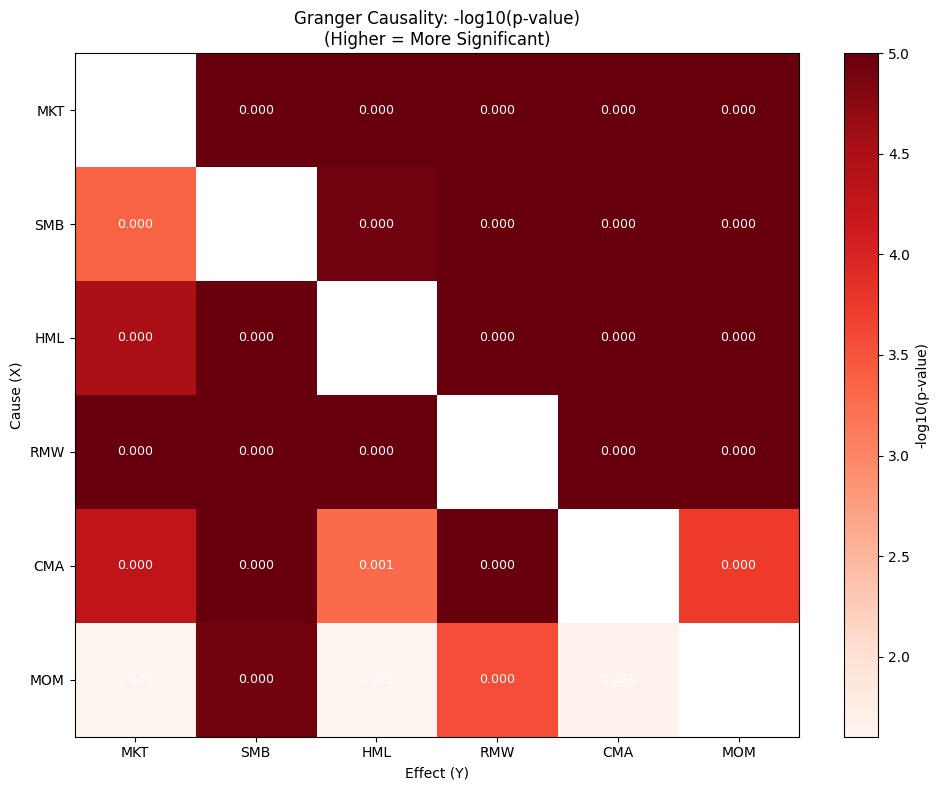


Significant causal relationships (p < 0.05): 30


In [11]:
# Visualize Granger causality matrix
fig, ax = plt.subplots(figsize=(10, 8))

# Convert p-values to significance (-log10)
significance = -np.log10(granger_pvalues.astype(float) + 1e-10)
significance = significance.clip(upper=5)  # Cap at 5 for visualization

im = ax.imshow(significance.values, cmap='Reds', aspect='auto')
ax.set_xticks(range(len(granger_pvalues.columns)))
ax.set_yticks(range(len(granger_pvalues.index)))
ax.set_xticklabels(granger_pvalues.columns)
ax.set_yticklabels(granger_pvalues.index)
ax.set_xlabel('Effect (Y)')
ax.set_ylabel('Cause (X)')
ax.set_title('Granger Causality: -log10(p-value)\n(Higher = More Significant)')

# Add text annotations
for i in range(len(granger_pvalues.index)):
    for j in range(len(granger_pvalues.columns)):
        p = granger_pvalues.iloc[i, j]
        if not np.isnan(p):
            text = f'{p:.3f}'
            color = 'white' if p < 0.05 else 'black'
            ax.text(j, i, text, ha='center', va='center', color=color, fontsize=9)

plt.colorbar(im, ax=ax, label='-log10(p-value)')
plt.tight_layout()
plt.show()

print(f"\nSignificant causal relationships (p < 0.05): {(granger_pvalues < 0.05).sum().sum()}")

## 5. Test 3: VAR Impulse Response

In [12]:
from statsmodels.tsa.api import VAR

# Fit VAR model
print("Fitting VAR model...")
model = VAR(crowding)

# Select optimal lag
lag_order = model.select_order(maxlags=15)
print(f"\nOptimal lag orders:")
print(f"  AIC: {lag_order.aic}")
print(f"  BIC: {lag_order.bic}")

# Fit with AIC-selected lag
results = model.fit(lag_order.aic)
print(f"\nFitted VAR({lag_order.aic})")

Fitting VAR model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Optimal lag orders:
  AIC: 15
  BIC: 2

Fitted VAR(15)


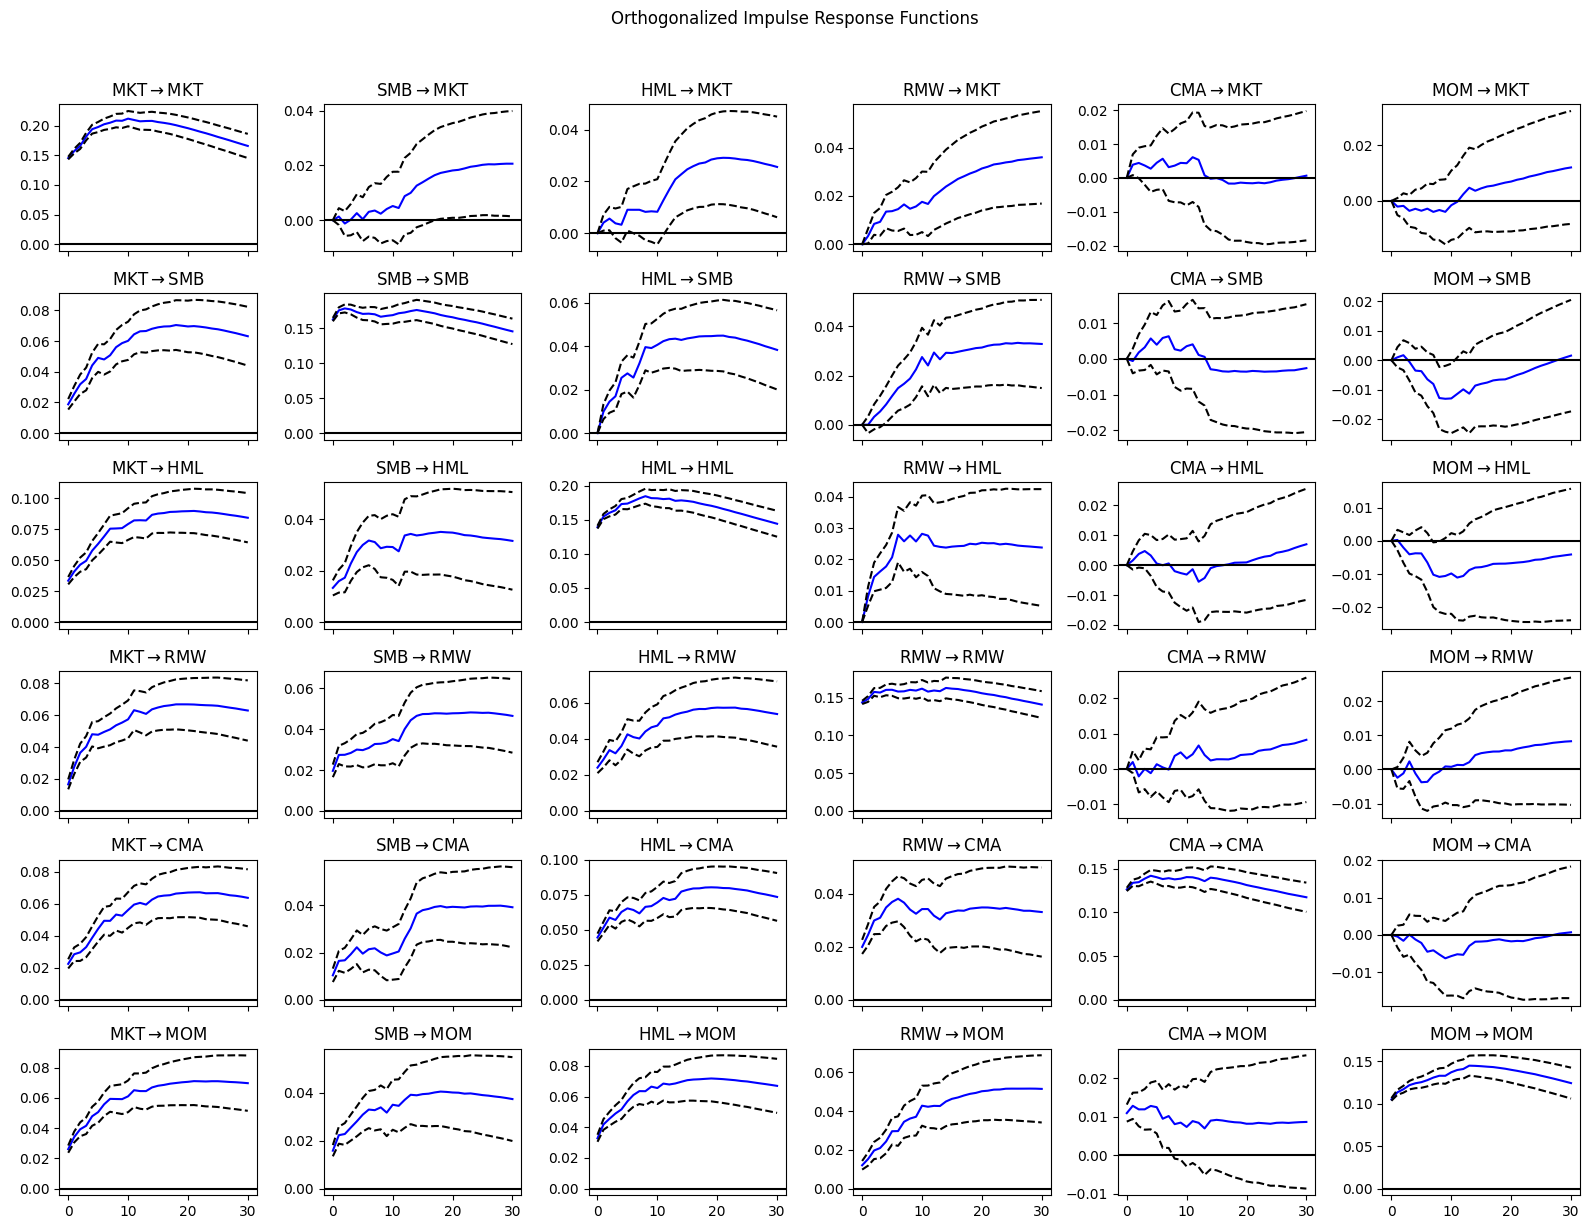

In [13]:
# Compute impulse response functions
irf = results.irf(periods=30)

# Plot impulse responses
fig = irf.plot(orth=True, figsize=(16, 12))
plt.suptitle('Orthogonalized Impulse Response Functions', y=1.02)
plt.tight_layout()
plt.show()

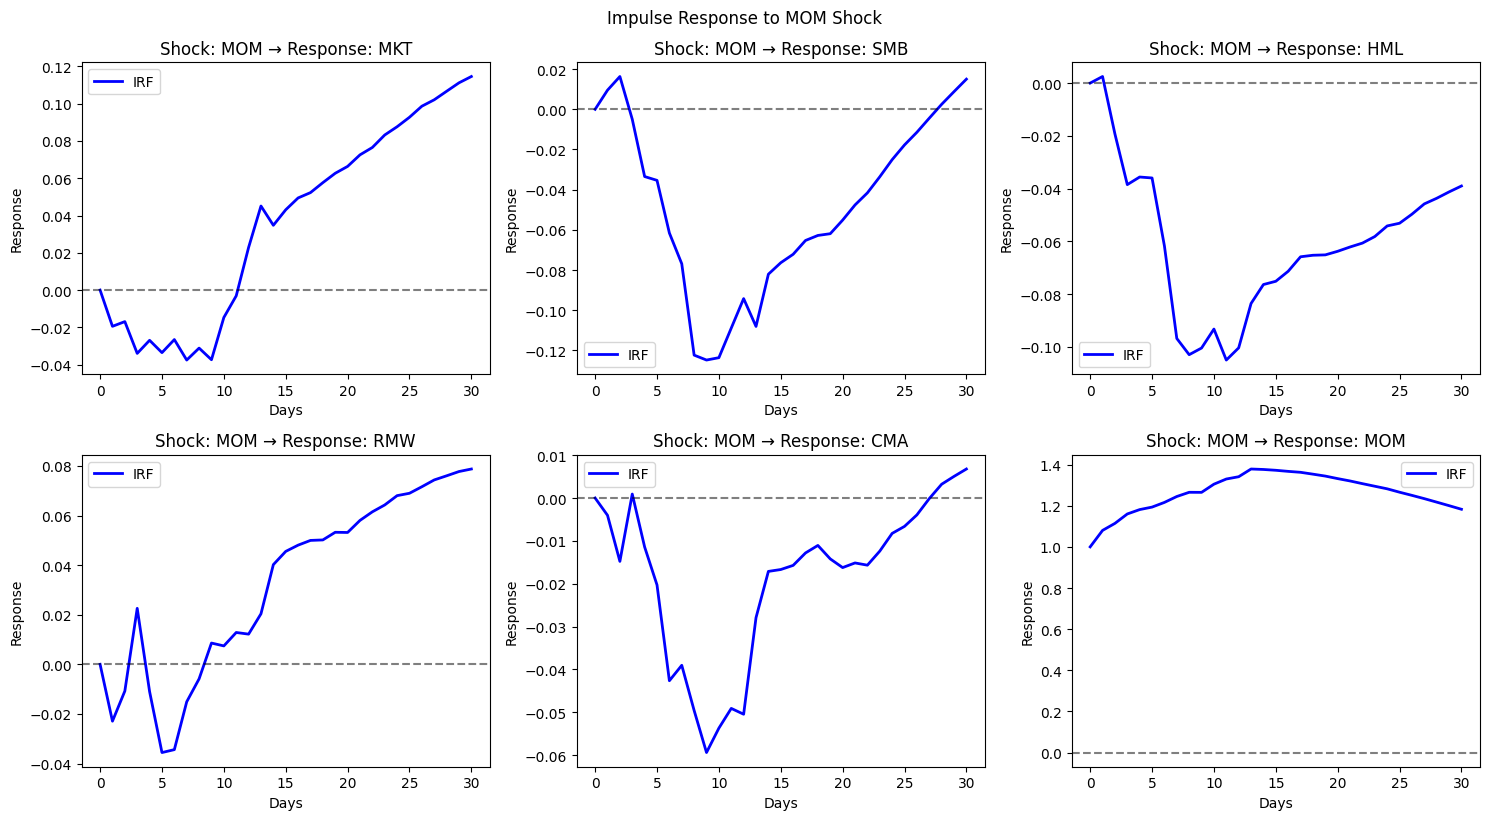

In [16]:
# Focus on key impulse responses (MOM shocks)
# fig, axes = plt.subplots(2, 3, figsize=(15, 8))
# axes = axes.flatten()

# shock_factor = 'MOM'
# shock_idx = list(crowding.columns).index(shock_factor)

# for i, response_factor in enumerate(crowding.columns):
#     response_idx = list(crowding.columns).index(response_factor)
    
#     # Get impulse response
#     ir = irf.irfs[:, response_idx, shock_idx]
#     ir_lower = irf.irfs_conf_int()[:, response_idx, shock_idx, 0]
#     ir_upper = irf.irfs_conf_int()[:, response_idx, shock_idx, 1]
    
#     periods = range(len(ir))
    
#     axes[i].plot(periods, ir, 'b-', linewidth=2, label='IRF')
#     axes[i].fill_between(periods, ir_lower, ir_upper, alpha=0.3, label='95% CI')
#     axes[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
#     axes[i].set_title(f'Shock: {shock_factor} → Response: {response_factor}')
#     axes[i].set_xlabel('Days')
#     axes[i].set_ylabel('Response')
#     axes[i].legend()

# plt.tight_layout()
# plt.suptitle(f'Impulse Response to {shock_factor} Shock', y=1.02)
# plt.show()

# Focus on key impulse responses (MOM shocks)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

shock_factor = 'MOM'
shock_idx = list(crowding.columns).index(shock_factor)

for i, response_factor in enumerate(crowding.columns):
    response_idx = list(crowding.columns).index(response_factor)

    # Get impulse response
    ir = irf.irfs[:, response_idx, shock_idx]
    periods = range(len(ir))

    axes[i].plot(periods, ir, 'b-', linewidth=2, label='IRF')
    axes[i].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[i].set_title(f'Shock: {shock_factor} → Response: {response_factor}')
    axes[i].set_xlabel('Days')
    axes[i].set_ylabel('Response')
    axes[i].legend()

plt.tight_layout()
plt.suptitle(f'Impulse Response to {shock_factor} Shock', y=1.02)
plt.show()

## 6. Test 4: Event Study - Crowding Spikes

In [17]:
def analyze_crowding_events(crowding, threshold=2.0, window=20):
    """
    When one factor has a crowding spike (>2 std), what happens to others?
    """
    results = []
    
    for shock_factor in crowding.columns:
        # Find spike days
        spike_days = crowding.index[crowding[shock_factor] > threshold]
        
        if len(spike_days) < 5:
            continue
        
        print(f"\n{shock_factor} spikes: {len(spike_days)} events")
        
        for response_factor in crowding.columns:
            if shock_factor == response_factor:
                continue
            
            # Collect response after spikes
            responses = []
            for spike_day in spike_days:
                try:
                    idx = crowding.index.get_loc(spike_day)
                    if idx + window >= len(crowding):
                        continue
                    
                    # Response = max crowding in next N days
                    future_max = crowding[response_factor].iloc[idx+1:idx+window+1].max()
                    baseline = crowding[response_factor].iloc[idx]
                    responses.append(future_max - baseline)
                except:
                    continue
            
            if len(responses) < 5:
                continue
            
            mean_response = np.mean(responses)
            t_stat, p_value = stats.ttest_1samp(responses, 0)
            
            results.append({
                'shock': shock_factor,
                'response': response_factor,
                'n_events': len(responses),
                'mean_increase': mean_response,
                't_stat': t_stat,
                'p_value': p_value
            })
            
            if p_value < 0.05:
                direction = "increases" if mean_response > 0 else "decreases"
                print(f"  → {response_factor} {direction}: mean={mean_response:.3f}, p={p_value:.4f}")
    
    return pd.DataFrame(results)

event_results = analyze_crowding_events(crowding, threshold=2.0, window=20)


MKT spikes: 958 events
  → SMB increases: mean=0.472, p=0.0000
  → HML increases: mean=0.359, p=0.0000
  → RMW increases: mean=0.359, p=0.0000
  → CMA increases: mean=0.392, p=0.0000
  → MOM increases: mean=0.425, p=0.0000

SMB spikes: 806 events
  → MKT increases: mean=0.454, p=0.0000
  → HML increases: mean=0.262, p=0.0000
  → RMW increases: mean=0.292, p=0.0000
  → CMA increases: mean=0.362, p=0.0000
  → MOM increases: mean=0.386, p=0.0000

HML spikes: 997 events
  → MKT increases: mean=0.289, p=0.0000
  → SMB increases: mean=0.442, p=0.0000
  → RMW increases: mean=0.443, p=0.0000
  → CMA increases: mean=0.336, p=0.0000
  → MOM increases: mean=0.345, p=0.0000

RMW spikes: 979 events
  → MKT increases: mean=0.516, p=0.0000
  → SMB increases: mean=0.488, p=0.0000
  → HML increases: mean=0.189, p=0.0000
  → CMA increases: mean=0.292, p=0.0000
  → MOM increases: mean=0.394, p=0.0000

CMA spikes: 872 events
  → MKT increases: mean=0.261, p=0.0000
  → SMB increases: mean=0.310, p=0.0000


## 7. Summary and Conclusions

In [18]:
print("="*70)
print("V10 VALIDATION SUMMARY: REAL FAMA-FRENCH DATA")
print("="*70)

# Cross-correlation summary
sig_xcorr = xcorr_results[
    (xcorr_results['peak_corr'].abs() > 0.15) & 
    (xcorr_results['peak_lag'].abs() > 2)
]
print(f"\n1. CROSS-CORRELATION: {len(sig_xcorr)} significant lead-lag relationships")
for _, row in sig_xcorr.iterrows():
    if row['peak_lag'] > 0:
        print(f"   {row['factor1']} → {row['factor2']}: lag={row['peak_lag']}d, corr={row['peak_corr']:.3f}")
    else:
        print(f"   {row['factor2']} → {row['factor1']}: lag={-row['peak_lag']}d, corr={row['peak_corr']:.3f}")

# Granger causality summary
n_granger = (granger_pvalues < 0.05).sum().sum()
print(f"\n2. GRANGER CAUSALITY: {n_granger} significant causal relationships (p<0.05)")
for cause in granger_pvalues.index:
    for effect in granger_pvalues.columns:
        p = granger_pvalues.loc[cause, effect]
        if p < 0.05:
            lag = granger_lags.loc[cause, effect]
            print(f"   {cause} → {effect}: p={p:.4f}, lag={int(lag)}d")

# Event study summary
if len(event_results) > 0:
    sig_events = event_results[event_results['p_value'] < 0.05]
    print(f"\n3. EVENT STUDY: {len(sig_events)} significant spillover effects")
    for _, row in sig_events.iterrows():
        direction = "↑" if row['mean_increase'] > 0 else "↓"
        print(f"   {row['shock']} spike → {row['response']} {direction}: p={row['p_value']:.4f}")

print("\n" + "="*70)
print("CONCLUSION")
print("="*70)

total_relationships = len(sig_xcorr) + n_granger
if total_relationships > 3:
    print("\n✅ VALIDATION PASSED: Multiple causal/lead-lag relationships found!")
    print("\nNext steps:")
    print("1. Apply formal causal discovery (DYNOTEARS, PCMCI)")
    print("2. Build causal-aware prediction model")
    print("3. Compare with correlation-based baselines")
elif total_relationships > 0:
    print("\n⚠️ PARTIAL VALIDATION: Some relationships found, but limited")
    print("Consider improving crowding proxy")
else:
    print("\n❌ VALIDATION FAILED: No significant relationships found")
    print("Need to revise crowding proxy or methodology")

V10 VALIDATION SUMMARY: REAL FAMA-FRENCH DATA

1. CROSS-CORRELATION: 0 significant lead-lag relationships

2. GRANGER CAUSALITY: 30 significant causal relationships (p<0.05)
   MKT → SMB: p=0.0000, lag=9d
   MKT → HML: p=0.0000, lag=9d
   MKT → RMW: p=0.0000, lag=5d
   MKT → CMA: p=0.0000, lag=7d
   MKT → MOM: p=0.0000, lag=16d
   SMB → MKT: p=0.0004, lag=18d
   SMB → HML: p=0.0000, lag=4d
   SMB → RMW: p=0.0000, lag=2d
   SMB → CMA: p=0.0000, lag=19d
   SMB → MOM: p=0.0000, lag=2d
   HML → MKT: p=0.0000, lag=14d
   HML → SMB: p=0.0000, lag=9d
   HML → RMW: p=0.0000, lag=12d
   HML → CMA: p=0.0000, lag=15d
   HML → MOM: p=0.0000, lag=2d
   RMW → MKT: p=0.0000, lag=3d
   RMW → SMB: p=0.0000, lag=14d
   RMW → HML: p=0.0000, lag=8d
   RMW → CMA: p=0.0000, lag=5d
   RMW → MOM: p=0.0000, lag=12d
   CMA → MKT: p=0.0001, lag=2d
   CMA → SMB: p=0.0000, lag=5d
   CMA → HML: p=0.0005, lag=16d
   CMA → RMW: p=0.0000, lag=17d
   CMA → MOM: p=0.0002, lag=2d
   MOM → MKT: p=0.0248, lag=13d
   MOM → 

In [19]:
# Save results for further analysis
results_summary = {
    'xcorr': xcorr_results,
    'granger_pvalues': granger_pvalues,
    'granger_lags': granger_lags,
    'event_results': event_results,
    'crowding': crowding,
    'factors': factors
}

print("\nResults saved to results_summary dict")
print("\nKey findings for paper:")
print("-" * 50)

# Most significant Granger relationships
print("\nTop Granger-causal relationships:")
granger_flat = []
for cause in granger_pvalues.index:
    for effect in granger_pvalues.columns:
        if cause != effect:
            granger_flat.append({
                'cause': cause,
                'effect': effect,
                'p_value': granger_pvalues.loc[cause, effect],
                'lag': granger_lags.loc[cause, effect]
            })

granger_df = pd.DataFrame(granger_flat).sort_values('p_value')
print(granger_df.head(10).to_string())


Results saved to results_summary dict

Key findings for paper:
--------------------------------------------------

Top Granger-causal relationships:
   cause effect       p_value   lag
11   HML    SMB  1.312657e-27   9.0
2    MKT    RMW  1.293363e-17   5.0
17   RMW    HML  3.411297e-15   8.0
0    MKT    SMB  8.431336e-14   9.0
4    MKT    MOM  1.714553e-13  16.0
14   HML    MOM  7.239590e-13   2.0
13   HML    CMA  1.136283e-12  15.0
19   RMW    MOM  1.181213e-11  12.0
8    SMB    CMA  1.807530e-11  19.0
12   HML    RMW  4.009803e-11  12.0
